In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
import tensorflow as tf
# Set the random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (16.0, 9.0)

from sklearn.utils import shuffle
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras import layers, models ,optimizers
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix ,classification_report
from sklearn.model_selection import train_test_split, KFold

2024-07-25 23:10:03.515507: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 23:10:03.515645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 23:10:03.699671: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
folder_benign_test = '/kaggle/input/skin-cancer-malignant-vs-benign/test/benign/'
folder_malignant_test = '/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant/'

folder_benign_train = '/kaggle/input/skin-cancer-malignant-vs-benign/train/benign/'
folder_malignant_train = '/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant/'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')



#  Merge train-test 
benign = np.concatenate((X_benign,X_benign_test), axis = 0)
malignant = np.concatenate((X_malignant,  X_malignant_test), axis = 0)

# Create labels
y_benign = np.zeros(benign.shape[0])
y_malignant = np.ones(malignant.shape[0])

#  Merge benign-malignant
data = np.concatenate((benign,malignant), axis = 0)
labels =  np.concatenate((y_benign,y_malignant), axis = 0)

In [3]:
# Shuffle data
data, labels = shuffle(data, labels, random_state=seed_value)

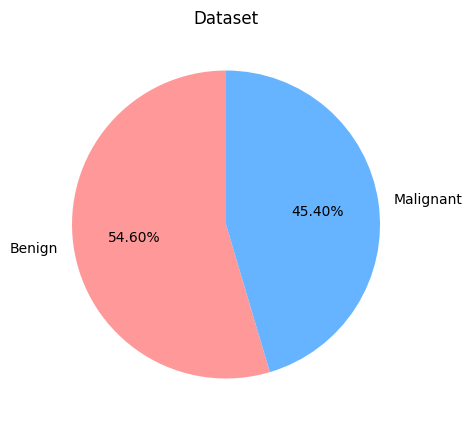

In [4]:
# Create a list of labels corresponding to the classes
values = ['Benign', 'Malignant']
plt.figure(figsize=(5, 5))
# Count the occurrences of each class in the training data
data_counts = [len(labels[labels == 0]), len(labels[labels == 1])]

# Plot the pie chart for the training data
plt.pie(data_counts, labels=values, autopct='%1.2f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title('Dataset')
plt.show()

In [5]:
print('data shape :',data.shape)
print('labels shape :',labels.shape)

data shape : (3297, 224, 224, 3)
labels shape : (3297,)


In [6]:
# Split the data and labels into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed_value)
# Split the test set further into test and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=seed_value)

In [7]:
# Create an instance of ImageDataGenerator for data augmentation on the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Create an instance of ImageDataGenerator for validation and test sets without augmentation
test_val_datagen = ImageDataGenerator()

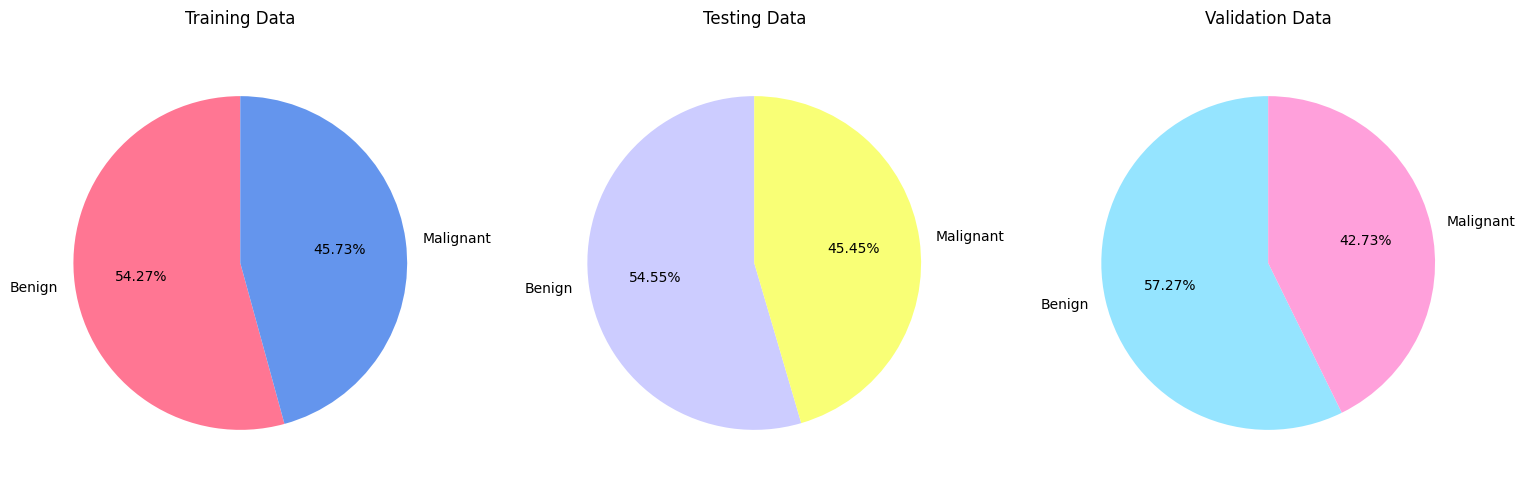

In [8]:
labels = ['Benign', 'Malignant']
# Count the occurrences of each class
train_counts = [len(y_train[y_train == 0]), len(y_train[y_train == 1])]
test_counts = [len(y_test[y_test == 0]), len(y_test[y_test == 1])]
val_counts = [len(y_val[y_val == 0]), len(y_val[y_val == 1])]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].pie(train_counts, labels=labels, autopct='%1.2f%%', startangle=90, colors=['#FF7693', '#6495ED'])
axes[0].set_title('Training Data')

axes[1].pie(test_counts, labels=labels, autopct='%1.2f%%', startangle=90, colors=['#CCCCFF', '#F9FF76'])
axes[1].set_title('Testing Data')

axes[2].pie(val_counts, labels=labels, autopct='%1.2f%%', startangle=90, colors=['#95E4FF', '#FFA0DB'])
axes[2].set_title('Validation Data')

# Set the aspect ratio to be equal for all subplots
axes[0].axis('equal')
axes[1].axis('equal')
axes[2].axis('equal')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4)
plt.show()

In [9]:
print('X_train shape :',X_train.shape)
print('y_train shape :',y_train.shape)
print('X_test shape :',X_test.shape)
print('y_test shape :',y_test.shape)
print('X_val shape :',X_val.shape)
print('y_val shape :',y_val.shape)

X_train shape : (2637, 224, 224, 3)
y_train shape : (2637,)
X_test shape : (330, 224, 224, 3)
y_test shape : (330,)
X_val shape : (330, 224, 224, 3)
y_val shape : (330,)


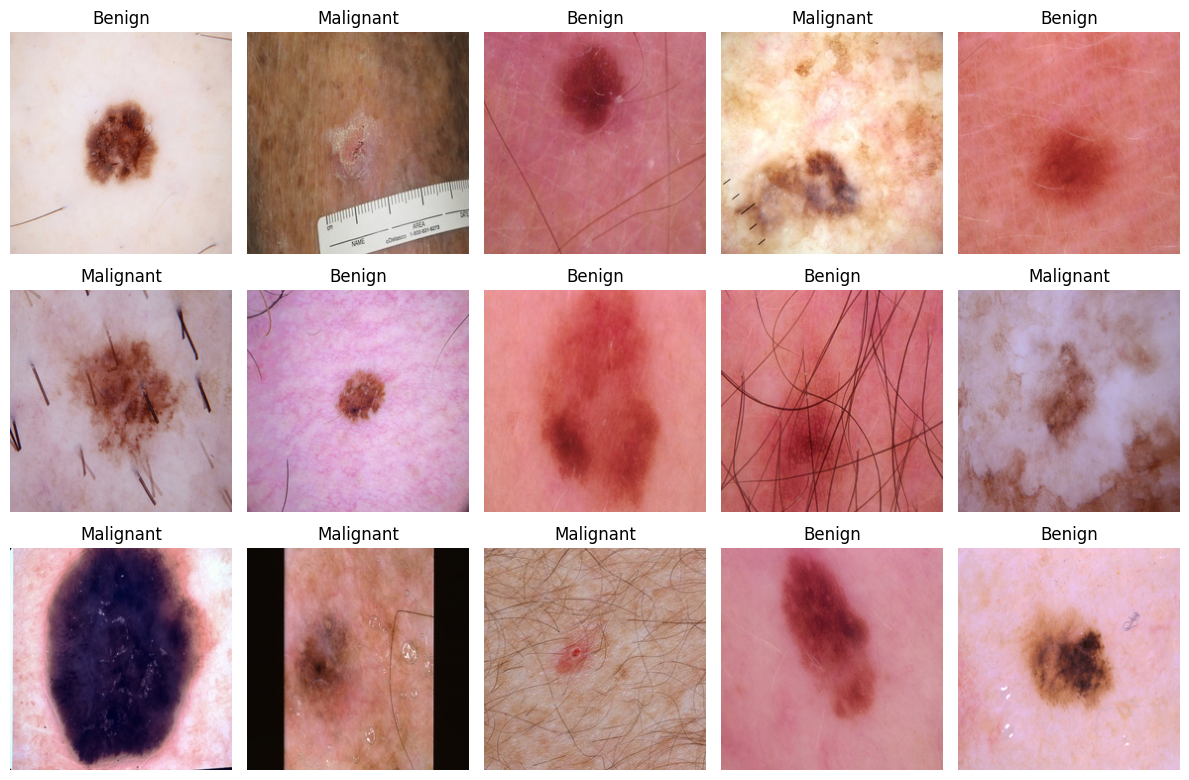

In [10]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))

# Iterate over the first 15 samples
for i, ax in enumerate(axes.flat):
    # Display the image
    ax.imshow(X_train[i])
    ax.set_axis_off()
    # Set the title based on the classification
    if y_train[i] == 0:
        ax.set_title('Benign')
    else:
        ax.set_title('Malignant')
# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

In [11]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)
y_val =to_categorical(y_val, num_classes= 2)

In [12]:
X_test = X_test/255
X_train = X_train/255
X_val = X_val/255

In [13]:
# Define the model
model = models.Sequential([
    
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(rate= 0.5, seed=seed_value),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate= 0.5, seed= seed_value),
    layers.Dense(2, activation='softmax')

])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,226 (24.86 MB)

 Trainable params: 6,516,098 (24.86 MB)

 Non-trainable params: 128 (512.00 B)

In [14]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-9, verbose=1)
# Fit the model using the augmented data generator for the training set and validation set
batch_size = 32
epochs = 50

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=test_val_datagen.flow(X_val, y_val, batch_size=batch_size),
    validation_steps=len(X_val) // batch_size,
    callbacks=[reduce_lr]
)

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.6403 - loss: 0.6457 - val_accuracy: 0.6250 - val_loss: 0.6593 - learning_rate: 1.0000e-05
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6250 - loss: 0.6230 - val_accuracy: 0.3000 - val_loss: 0.7198 - learning_rate: 1.0000e-05
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.7721 - loss: 0.4930 - val_accuracy: 0.7750 - val_loss: 0.6426 - learning_rate: 1.0000e-05
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8750 - loss: 0.3014 - val_accuracy: 0.7000 - val_loss: 0.6403 - learning_rate: 1.0000e-05
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.7812 - loss: 0.4423 - val_accuracy: 0.7719 - val_loss: 0.6145 - learning_rate: 1.0000e-05
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7500 - loss: 0.4685 - val_accuracy: 0.8000 - val_loss: 0.5964 - learning_rate: 1.0000e-05
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.7826 -

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
test_accuracy = accuracy * 100
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}%')

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 533ms/step - accuracy: 0.8150 - loss: 0.3868
Test loss: 0.3942
Test accuracy: 80.6061%


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 532ms/step


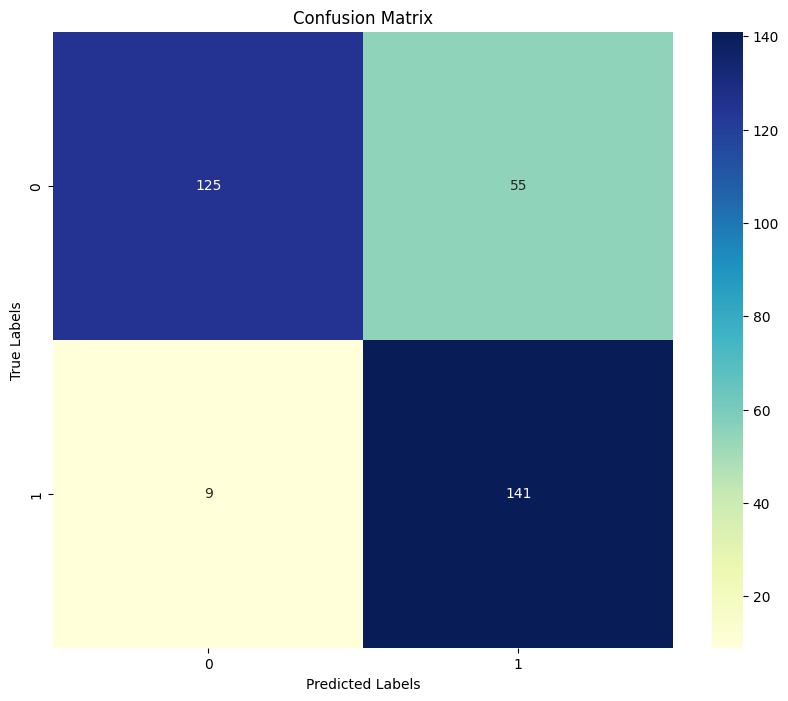

In [17]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="YlGnBu")
# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Show the plot
plt.show()

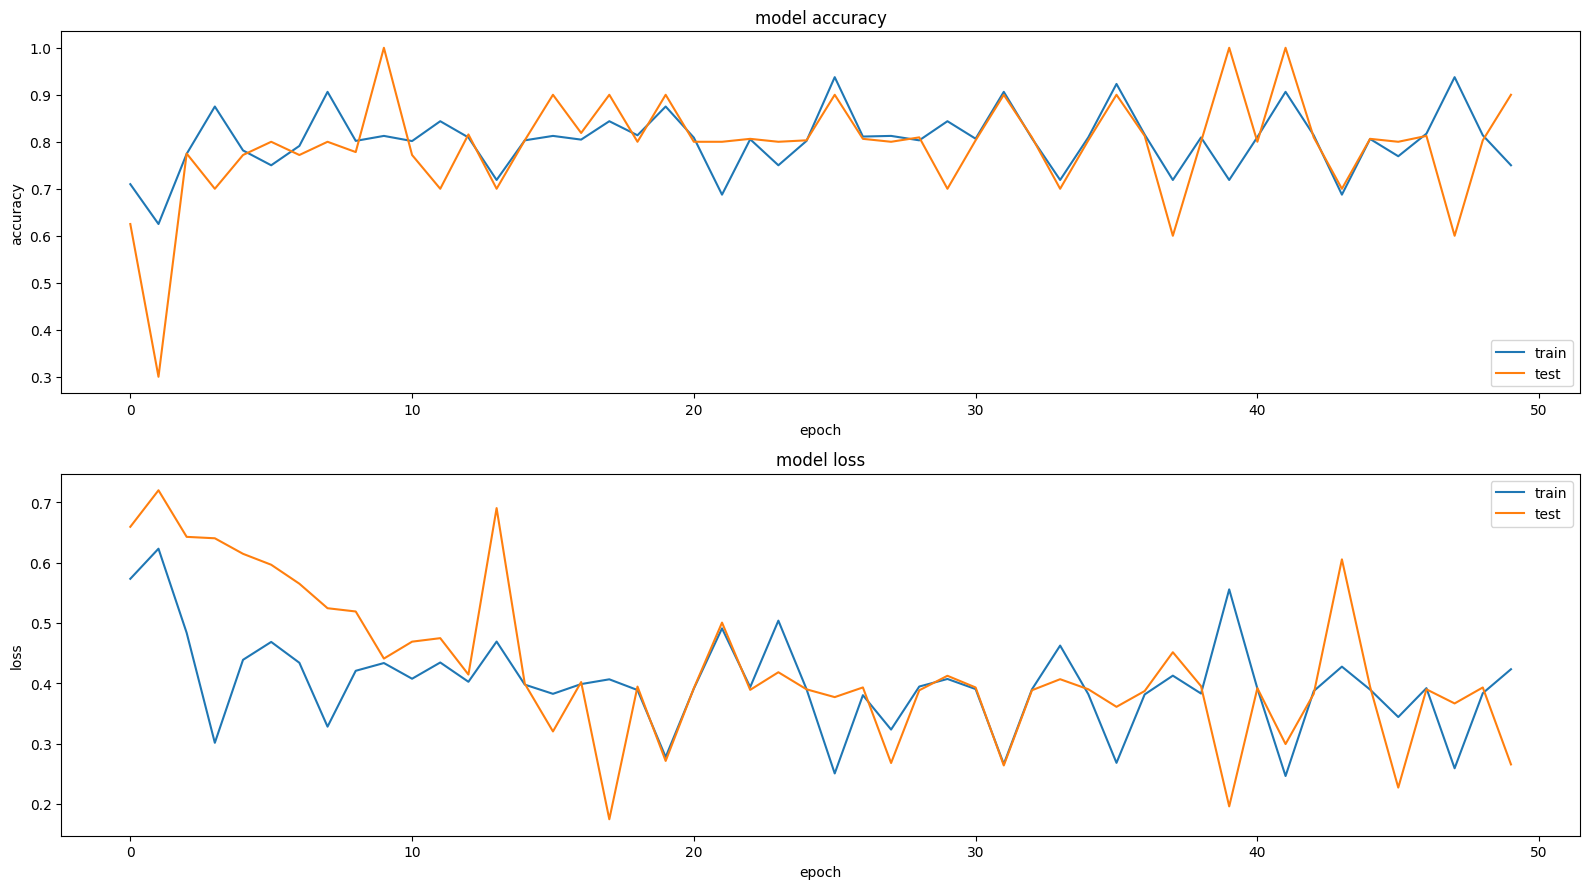

In [18]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()
plt.show()

In [19]:
y_pred_report = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Convert one-hot encoded labels to class labels
y_true = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred_report)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.69      0.80       180
           1       0.72      0.94      0.82       150

    accuracy                           0.81       330
   macro avg       0.83      0.82      0.81       330
weighted avg       0.84      0.81      0.80       330



In [20]:
def create_model():
    cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(rate= 0.5, seed=seed_value),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate= 0.5, seed= seed_value),
    layers.Dense(2, activation='softmax')
    ])
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, min_lr=1e-9)
    cnn.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    history = cnn.fit(X_train, y_train, batch_size=32,
    steps_per_epoch=len(X_train) // 32,
    epochs=30,
    callbacks=[reduce_lr],
    verbose=0
    )
    return cnn

In [21]:
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=seed_value)
cvscores = []
for train, test in kfold.split(X_train, y_train):
    model = create_model()
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

compile_metrics: 83.73%
compile_metrics: 84.53%
compile_metrics: 79.98%
82.75% (+/- 1.98%)
